In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [32]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

## specify # of nodes
Nin: int = 2
extraNin: int = 0
Ninter: int = 0
Nout: int = 1
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.2  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 1.9, 1., 1.85, 1.05, 1.9, 1., 0.85])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]

# length of training dataset
iterations = 1400  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 30

# noise_to_extra: bool = True  # add noise to extra outputs 
noise_to_extra: bool = False  # add noise to extra outputs 

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 1.0  # noise to dual problem
# use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
use_p_tag: bool = False
# access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
# stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
stay_sample: int = 80

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [33]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [0.2]
input M mismatches output and input
no extra input nodes, no noise added
no inter nodes, no noise added
no extra output nodes, no noise added


In [34]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [35]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0 1]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [2]
extraOutput_nodes_arr  []
ground_nodes_arr  [3]


In [36]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [37]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [38]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs, Ninter)
else:
    State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

R_vec_i has wrong size, initializing all ones


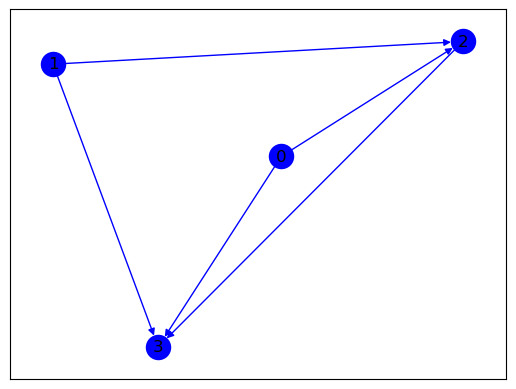

NET is ready


In [39]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [40]:
Strctr.EIEJ_plots

[(0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

## Train

In [41]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")    
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        if not((i+1) % 4):
            State.update_inter_dual(BigClass)
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t):
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
inter measured= []
output measured= [0.88350295]
extraOutput measured= []
time= 1
loss after calc_loss [[-0.39085519]]
input_dual_nxt= [1.05855638 1.14863665]
output_dual_nxt [0.43093566]
i 1
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
inter measured= []
output measured= [0.72408508]
extraOutput measured= []
time= 2
loss after calc_loss [[-0.23143732]]
input_dual_nxt= [1.0932294  1.23664896]
output_dual_nxt [0.39741959]
i 2
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
inter measured= []
output measured= [0.64961294]
extraOutput measured= []
time= 3
loss after calc_loss [[-0.15696519]]
input_dual_nxt= [1.11674531 1.29634058]
output_dual_nxt [0.37702627]
i 3
k 0
input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
inter measured= []
output measured= [0.60506419]
extraOutput measured= []
time= 4
loss after calc_loss [[-0.11241643]]
updating inters
loss for 

inter measured= []
output measured= [0.10668211]
extraOutput measured= []
time= 175
loss after calc_loss [[0.00252129]]
input_dual_nxt= [1.28778975 1.55843707]
output_dual_nxt [0.29021215]
i 175
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034]
inter measured= []
output measured= [0.10670859]
extraOutput measured= []
time= 176
loss after calc_loss [[0.00249481]]
updating inters
loss for inters update [[0.00249481]]
inter_dual_nxt= []
i 176
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034]
inter measured= []
output measured= [0.10670859]
extraOutput measured= []
time= 177
loss after calc_loss [[0.00249481]]
input_dual_nxt= [1.28763406 1.5582814 ]
output_dual_nxt [0.29026539]
i 177
k 2
input_drawn [0.31203728 0.31198904]
desired output= [0.1092034]
inter measured= []
output measured= [0.1067348]
extraOutput measured= []
time= 178
loss after calc_loss [[0.0024686]]
input_dual_nxt= [1.28748    1.55812736]
output_dual_nxt [0.29031809]
i 178
k 2
input_draw

inter measured= []
output measured= [0.46439572]
extraOutput measured= []
time= 347
loss after calc_loss [[-0.00083219]]
input_dual_nxt= [1.3449627  1.42862258]
output_dual_nxt [0.29966519]
i 347
k 4
input_drawn [1.20223002 1.41614516]
desired output= [0.46356353]
inter measured= []
output measured= [0.46423726]
extraOutput measured= []
time= 348
loss after calc_loss [[-0.00067372]]
updating inters
loss for inters update [[-0.00067372]]
inter_dual_nxt= []
i 348
k 4
input_drawn [1.20223002 1.41614516]
desired output= [0.46356353]
inter measured= []
output measured= [0.46423726]
extraOutput measured= []
time= 349
loss after calc_loss [[-0.00067372]]
input_dual_nxt= [1.3451247 1.4288134]
output_dual_nxt [0.29960263]
i 349
k 4
input_drawn [1.20223002 1.41614516]
desired output= [0.46356353]
inter measured= []
output measured= [0.46410902]
extraOutput measured= []
time= 350
loss after calc_loss [[-0.00054548]]
input_dual_nxt= [1.34525585 1.4289679 ]
output_dual_nxt [0.299552]
i 350
k 4
inpu

inter measured= []
output measured= [0.33547667]
extraOutput measured= []
time= 523
loss after calc_loss [[-0.00080824]]
input_dual_nxt= [1.50637309 1.34896697]
output_dual_nxt [0.2858445]
i 523
k 6
input_drawn [1.66488528 0.42467822]
desired output= [0.33466844]
inter measured= []
output measured= [0.3353776]
extraOutput measured= []
time= 524
loss after calc_loss [[-0.00070916]]
updating inters
loss for inters update [[-0.00070916]]
inter_dual_nxt= []
i 524
k 6
input_drawn [1.66488528 0.42467822]
desired output= [0.33466844]
inter measured= []
output measured= [0.3353776]
extraOutput measured= []
time= 525
loss after calc_loss [[-0.00070916]]
input_dual_nxt= [1.50660922 1.3490272 ]
output_dual_nxt [0.28579693]
i 525
k 6
input_drawn [1.66488528 0.42467822]
desired output= [0.33466844]
inter measured= []
output measured= [0.33529071]
extraOutput measured= []
time= 526
loss after calc_loss [[-0.00062227]]
input_dual_nxt= [1.50681643 1.34908006]
output_dual_nxt [0.28575521]
i 526
k 6
inp

inter measured= []
output measured= [0.3008992]
extraOutput measured= []
time= 696
loss after calc_loss [[0.00027604]]
updating inters
loss for inters update [[0.00027604]]
inter_dual_nxt= []
i 696
k 8
input_drawn [0.60848449 1.04951286]
desired output= [0.30117525]
inter measured= []
output measured= [0.3008992]
extraOutput measured= []
time= 697
loss after calc_loss [[0.00027604]]
input_dual_nxt= [1.4750018  1.30448014]
output_dual_nxt [0.29908986]
i 697
k 8
input_drawn [0.60848449 1.04951286]
desired output= [0.30117525]
inter measured= []
output measured= [0.30092277]
extraOutput measured= []
time= 698
loss after calc_loss [[0.00025248]]
input_dual_nxt= [1.47497108 1.30442715]
output_dual_nxt [0.29910506]
i 698
k 8
input_drawn [0.60848449 1.04951286]
desired output= [0.30117525]
inter measured= []
output measured= [0.30094432]
extraOutput measured= []
time= 699
loss after calc_loss [[0.00023093]]
input_dual_nxt= [1.47494297 1.30437867]
output_dual_nxt [0.29911895]
i 699
k 8
input_d

i 878
k 10
input_drawn [1.22370579 0.27898772]
desired output= [0.23935341]
inter measured= []
output measured= [0.23950907]
extraOutput measured= []
time= 879
loss after calc_loss [[-0.00015566]]
input_dual_nxt= [1.52461869 1.32508627]
output_dual_nxt [0.28733776]
i 879
k 10
input_drawn [1.22370579 0.27898772]
desired output= [0.23935341]
inter measured= []
output measured= [0.23949926]
extraOutput measured= []
time= 880
loss after calc_loss [[-0.00014585]]
updating inters
loss for inters update [[-0.00014585]]
inter_dual_nxt= []
i 880
k 11
input_drawn [0.5842893  0.73272369]
desired output= [0.23418813]
inter measured= []
output measured= [0.22435086]
extraOutput measured= []
time= 881
loss after calc_loss [[0.00983728]]
input_dual_nxt= [1.52346913 1.32364467]
output_dual_nxt [0.28777916]
i 881
k 11
input_drawn [0.5842893  0.73272369]
desired output= [0.23418813]
inter measured= []
output measured= [0.22481997]
extraOutput measured= []
time= 882
loss after calc_loss [[0.00936816]]
in

inter measured= []
output measured= [0.45089135]
extraOutput measured= []
time= 1035
loss after calc_loss [[2.51353974e-08]]
input_dual_nxt= [1.49823693 1.29015081]
output_dual_nxt [0.29806786]
i 1035
k 12
input_drawn [0.91213997 1.57035192]
desired output= [0.45089138]
inter measured= []
output measured= [0.45089136]
extraOutput measured= []
time= 1036
loss after calc_loss [[2.02751111e-08]]
updating inters
loss for inters update [[2.02751111e-08]]
inter_dual_nxt= []
i 1036
k 12
input_drawn [0.91213997 1.57035192]
desired output= [0.45089138]
inter measured= []
output measured= [0.45089136]
extraOutput measured= []
time= 1037
loss after calc_loss [[2.0275111e-08]]
input_dual_nxt= [1.49823693 1.29015081]
output_dual_nxt [0.29806786]
i 1037
k 12
input_drawn [0.91213997 1.57035192]
desired output= [0.45089138]
inter measured= []
output measured= [0.45089136]
extraOutput measured= []
time= 1038
loss after calc_loss [[1.63546302e-08]]
input_dual_nxt= [1.49823693 1.2901508 ]
output_dual_nxt

i 1193
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454]
inter measured= []
output measured= [0.19703713]
extraOutput measured= []
time= 1194
loss after calc_loss [[-0.00073259]]
input_dual_nxt= [1.55117965 1.28865078]
output_dual_nxt [0.29010417]
i 1194
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454]
inter measured= []
output measured= [0.19700108]
extraOutput measured= []
time= 1195
loss after calc_loss [[-0.00069655]]
input_dual_nxt= [1.55134471 1.28866372]
output_dual_nxt [0.29007673]
i 1195
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454]
inter measured= []
output measured= [0.19696682]
extraOutput measured= []
time= 1196
loss after calc_loss [[-0.00066228]]
updating inters
loss for inters update [[-0.00066228]]
inter_dual_nxt= []
i 1196
k 14
input_drawn [1.18482914 0.09290083]
desired output= [0.19630454]
inter measured= []
output measured= [0.19696682]
extraOutput measured= []
time= 1197
loss after calc_loss [[-0.000

inter measured= []
output measured= [0.39906935]
extraOutput measured= []
time= 1342
loss after calc_loss [[3.42552259e-07]]
input_dual_nxt= [1.54381294 1.25848468]
output_dual_nxt [0.29710957]
i 1342
k 16
input_drawn [0.13010319 1.89777107]
desired output= [0.39906969]
inter measured= []
output measured= [0.39906942]
extraOutput measured= []
time= 1343
loss after calc_loss [[2.71030452e-07]]
input_dual_nxt= [1.54381294 1.25848458]
output_dual_nxt [0.29710959]
i 1343
k 16
input_drawn [0.13010319 1.89777107]
desired output= [0.39906969]
inter measured= []
output measured= [0.39906948]
extraOutput measured= []
time= 1344
loss after calc_loss [[2.14441736e-07]]
updating inters
loss for inters update [[2.14441736e-07]]
inter_dual_nxt= []
i 1344
k 16
input_drawn [0.13010319 1.89777107]
desired output= [0.39906969]
inter measured= []
output measured= [0.39906948]
extraOutput measured= []
time= 1345
loss after calc_loss [[2.14441736e-07]]
input_dual_nxt= [1.54381293 1.2584845 ]
output_dual_nx

In [42]:
State.inter_in_t

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 

In [43]:
BigClass.Strctr.extraOutput_nodes_arr

array([], dtype=int32)

In [44]:
Strctr.EIEJ_plots

[(0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

In [45]:
State.R_in_t[-1]

array([1.25763712, 0.97095936, 1.55209796, 1.2654202 , 0.29446085])

## Plots

### importants + network

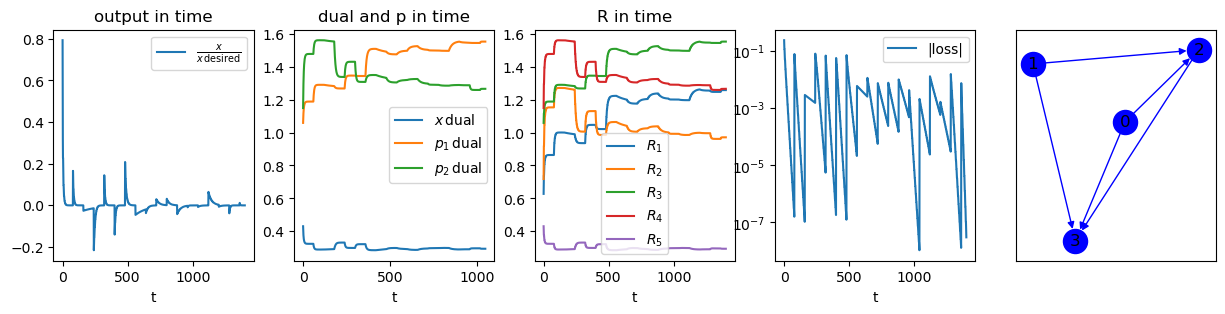

In [46]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

### accuracy

In [18]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(Variabs, State)
else:
    pass

In [19]:
np.mean(np.abs(State.loss_in_t[-1000:]))

0.05290955500255738

## Save sizes to file

In [20]:
# R_propto_deltap = State.R_in_t
# deltaR_propto_deltap = State.R_in_t
# deltaR_propto_Q = State.R_in_t
# deltaR_propto_Power = State.R_in_t

# loss_R_propto_deltap = State.loss_in_t
# loss_deltaR_propto_deltap = State.loss_in_t
# loss_propto_Q = State.loss_in_t
# loss_propto_Power = State.loss_in_t

In [21]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)

In [22]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [23]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

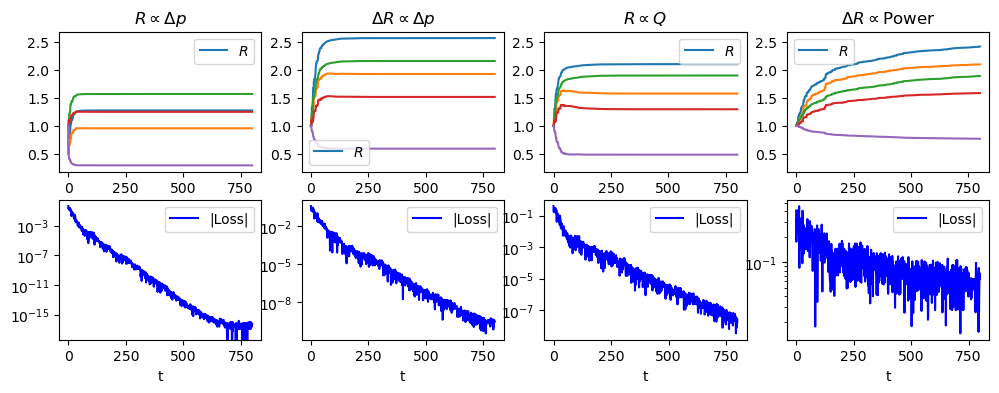

In [24]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [25]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [26]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [27]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [28]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

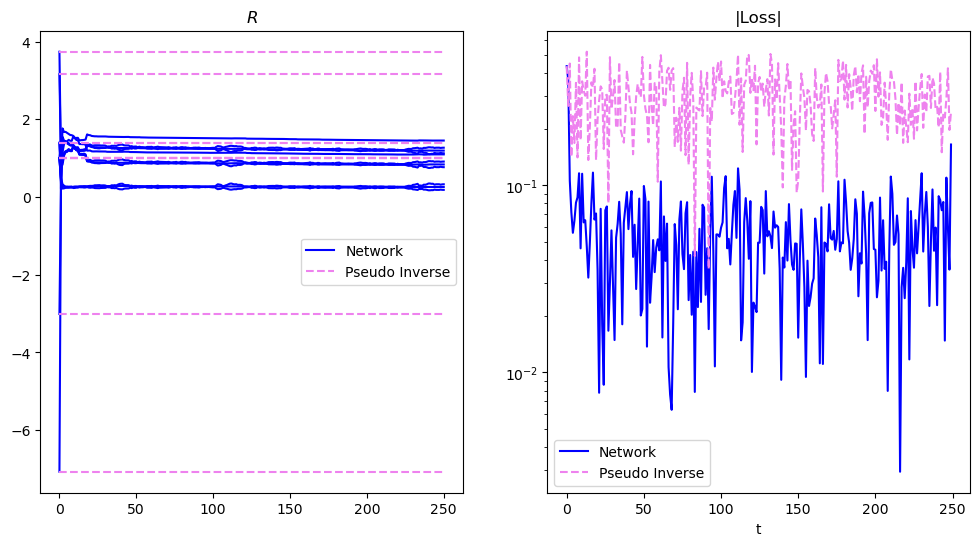

In [29]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Statistics

### Error

In [30]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.004433802697951465


### Accuracy

In [31]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    print('net prediction', np.sum((State.targets_mat - State.output)**2, axis=1))
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.74908024 1.90142861]
desired output= [0.49264776]
inter measured= []
output measured= [0.49226286]
extraOutput measured= []


AttributeError: 'Network_State' object has no attribute 'targets_mat'

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)